<a href="https://colab.research.google.com/github/hossein20s/forecast/blob/master/pytorch_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch-forecasting

     |████████████████████████████████| 102kB 7.3MB/s 
     |████████████████████████████████| 686kB 19.5MB/s 
     |████████████████████████████████| 22.2MB 1.8MB/s 
     |████████████████████████████████| 102kB 14.3MB/s 
     |████████████████████████████████| 286kB 52.3MB/s 
     |████████████████████████████████| 276kB 48.3MB/s 
     |████████████████████████████████| 829kB 35.7MB/s 
     |████████████████████████████████| 81kB 11.3MB/s 
     |████████████████████████████████| 163kB 50.0MB/s 
     |████████████████████████████████| 112kB 56.4MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 133kB 55.7MB/s 
     |████████████████████████████████| 81kB 12.7MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=69e4a383422b727965ccd9ad20cb3e8db8dfbf104db0ee9c4af2e16492c210f9
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created

# Pytorch-Forcasting 
From https://towardsdatascience.com/introducing-pytorch-forecasting-64de99b9ef46


In [2]:
from pytorch_forecasting.data.examples import get_stallion_data
data = get_stallion_data()

In [4]:
import numpy

# add time index
data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
data["time_idx"] -= data["time_idx"].min()

# add additional features
data["month"] = data.date.dt.month.astype(str).astype("category")  # categories have be strings
data["log_volume"] = numpy.log(data.volume + 1e-8)
data["avg_volume_by_sku"] = data.groupby(["time_idx", "sku"], observed=True).volume.transform("mean")
data["avg_volume_by_agency"] = data.groupby(["time_idx", "agency"], observed=True).volume.transform("mean")

# we want to encode special days as one variable and thus need to first reverse one-hot encoding
special_days = [
    "easter_day",
    "good_friday",
    "new_year",
    "christmas",
    "labor_day",
    "independence_day",
    "revolution_day_memorial",
    "regional_games",
    "fifa_u_17_world_cup",
    "football_gold_cup",
    "beer_capital",
    "music_fest",
]
data[special_days] = data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
print(data.sample(10, random_state=521))
print(data.describe())


          agency     sku  ...  avg_volume_by_sku avg_volume_by_agency
291    Agency_25  SKU_03  ...        1225.306376            99.650400
871    Agency_29  SKU_02  ...        1634.434615            11.397086
19532  Agency_47  SKU_01  ...        2625.472644            48.295650
2089   Agency_53  SKU_07  ...          38.529107          2511.035175
9755   Agency_17  SKU_02  ...        2143.677462           396.022140
7561   Agency_05  SKU_03  ...        1566.643589          1881.866367
19204  Agency_11  SKU_05  ...        1385.225478           109.699200
8781   Agency_48  SKU_04  ...        1757.950603          1925.272108
2540   Agency_07  SKU_21  ...           0.000000          2418.719550
12084  Agency_21  SKU_03  ...        2034.293024           109.381800

[10 rows x 31 columns]
             volume  industry_volume  ...  avg_volume_by_sku  avg_volume_by_agency
count  21000.000000     2.100000e+04  ...       21000.000000          21000.000000
mean    1492.403982     5.439214e+08  ..

In [6]:
from pytorch_forecasting import TimeSeriesDataSet, GroupNormalizer, Baseline, TemporalFusionTransformer

max_prediction_length = 6
max_encoder_length = 24
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="volume",
    group_ids=["agency", "sku"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["agency", "sku"],
    static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    time_varying_known_categoricals=["special_days", "month"],
    variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "volume",
        "log_volume",
        "industry_volume",
        "soda_volume",
        "avg_max_temp",
        "avg_volume_by_agency",
        "avg_volume_by_sku",
    ],
    target_normalizer=GroupNormalizer(
        groups=["agency", "sku"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

print("create baseline")


/usr/local/lib/python3.6/dist-packages/pytorch_forecasting/data/timeseries.py:364: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["relative_time_idx"] = 0.0  # dummy - real value will be set dynamiclly in __getitem__()
/usr/local/lib/python3.6/dist-packages/pytorch_forecasting/data/timeseries.py:373: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["encoder_length"] = 0  # dummy - real value will be set dynamiclly in __getitem__()


create baseline


In [8]:
import torch

# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, y in iter(val_dataloader)][0][:-1])
baseline_predictions = Baseline().predict(val_dataloader)
result = (actuals - baseline_predictions).abs().mean().item()

print(result)


293.0088195800781


In [11]:
import pytorch_lightning
from pytorch_forecasting.metrics import QuantileLoss

print("configure network and trainer")

pytorch_lightning.seed_everything(42)
trainer = pytorch_lightning.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")


Global seed set to 42
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: False
TPU available: None, using: 0 TPU cores


configure network and trainer
Number of parameters in network: 29.7k


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


In [1]:
#mount google colab acoount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Day Ahead market prediction using ARIMA
From https://towardsdatascience.com/can-we-predict-the-day-ahead-electricity-market-f532137fd5be


In [2]:
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [3]:
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1VY22j4rgXXx3Rl8nQFOU20TZE_CF7ssJBu-AF9ZBYYU/edit#gid=1671056156')
sheet = wb.worksheet('clean_n2ex_2016_hourly.csv')
data = sheet.get_all_values()

In [20]:
import pandas as pd

df = pd.DataFrame(data)
df.columns = df.iloc[0]
df = df.iloc[1:]
df.shape

(8784, 5)

In [23]:
df['month'] = pd.DatetimeIndex(df['date']).month
df['hour_start'] = pd.to_datetime(df['hour_start'], format='%H').dt.hour
df['date_time'] = df['date'].astype(str) + ' ' +df['hour_start'].astype(str)
df['season'] = ['winter' if i < 3 or i == 12 else 'Autumn' if i >= 9 and i <= 11 else 'Spring' if i >= 3 and i <= 5 else 'Summer' for i in df['month']]


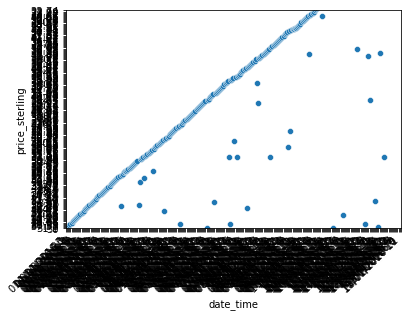

In [24]:
    xticklabels = df['date_time']
    l = sns.scatterplot(data=df, x='date_time', y='price_sterling')
    l.set(xlim=(0,300),ylim=(0,200))
    l.set_xticklabels(xticklabels, rotation=45, ha='right')
    plt.tight_layout
    plt.setp(l.get_xticklabels(), visible=True)
    plt.show()


In [33]:
    from statsmodels.tsa.stattools import adfuller
    
    df1 = df.loc[:200, 'price_sterling'].astype(float)
    X = df1.values
    print(X)
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))



[30.   31.1  37.58 36.53 29.91 27.96 29.88 18.04 12.75 14.21 20.   31.07
 34.98 40.9  37.25 31.53 34.52 46.41 64.5  39.55 37.51 35.   34.94 26.91
 33.6  34.07 32.96 21.53 18.    9.9  14.97 20.74 17.   24.62 34.93 43.6
 38.9  43.27 37.1  35.22 32.04 32.5  70.   55.08 40.84 37.55 33.98 33.15
 37.56 37.51 37.53 34.96 34.49 29.82 29.82 25.41 28.21 24.98 30.22 31.03
 33.82 39.63 36.03 34.5  30.24 35.   70.   50.86 40.   38.   33.98 32.05
 33.75 31.81 35.55 35.39 33.91 30.06 29.82 29.93 30.57 35.04 37.99 37.08
 40.11 40.2  38.05 35.05 34.52 40.79 78.27 42.81 40.55 43.   36.06 34.
 30.93 29.99 31.95 29.97 27.99 24.32 29.91 43.01 36.1  37.01 36.2  35.86
 37.91 38.8  34.95 30.74 30.7  43.03 74.96 49.04 41.92 38.74 37.05 30.35
 32.37 30.4  32.44 30.53 29.92 24.07 30.   38.03 36.74 42.9  43.59 40.05
 34.08 33.6  32.11 31.96 31.05 44.64 69.   40.72 37.94 36.46 35.07 30.5
 38.07 38.06 38.   29.91 27.   23.94 26.93 38.05 35.69 38.   39.65 38.99
 37.35 35.82 33.57 33.48 32.1  45.07 64.5  44.61 39.04 

1      30.00
2      31.10
3      37.58
4      36.53
5      29.91
       ...  
196    32.82
197    31.01
198    27.54
199    27.41
200    30.57
Name: price_sterling, Length: 200, dtype: float64


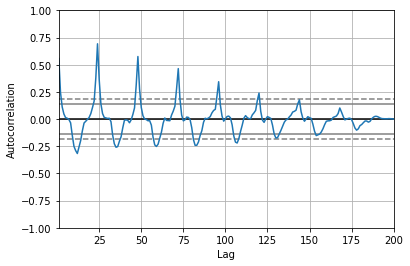

In [34]:
    corr_data = df.loc[:200, 'price_sterling'].astype(float)
    corr_data = corr_data.replace(np.nan, 0)
    print(corr_data)
    autocorrelation_plot(corr_data)
    plt.show()


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:       D.price_sterling   No. Observations:                  199
Model:                 ARIMA(2, 1, 5)   Log Likelihood                -694.767
Method:                       css-mle   S.D. of innovations              7.760
Date:                Wed, 13 Jan 2021   AIC                           1407.535
Time:                        05:44:46   BIC                           1437.174
Sample:                             1   HQIC                          1419.531
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0317      0.018      1.719      0.087      -0.004       0.068
ar.L1.D.price_sterling    -1.4171      0.018    -79.047      0.000      -1.452      -1.382
ar.L

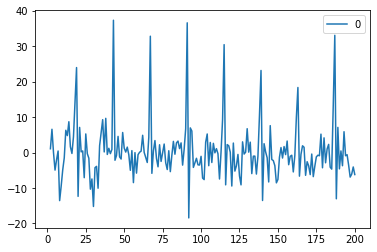

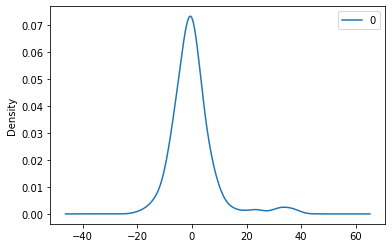

                0
count  199.000000
mean     0.255599
std      7.947247
min    -18.429577
25%     -3.803187
50%     -0.528979
75%      2.444750
max     37.298961


In [36]:
    df1 = df.loc[ :200, 'price_sterling'].astype(float)
    model = ARIMA(df1, order=(2,1,5))
    model_fit = model.fit(disp=0)
    print(model_fit.summary())
    residuals = pd.DataFrame(model_fit.resid)
    residuals.plot()
    plt.show()
    residuals.plot(kind='kde')
    plt.show()
    print(residuals.describe())


In [38]:
    warnings.filterwarnings("ignore")
    df1 = df['price_sterling'].astype(float)
    df2 = df1.loc[:300]
    X = df2.values
    size = int(len(X) * 0.66)
    train, test = X[0:size] , X[size:len(X)]
    history = [x for x in train]
    p = d = q = range(0,6)
    pdq = list(itertools.product(p,d,q))
    aic_results = []
    parameter = []
    for param in pdq:
        try:
            model = ARIMA(history, order=param)
            results = model.fit(disp=0)
            print('ARIMA{} - AIC:{}'.format(param, results.aic))
            aic_results.append(results.aic)
            parameter.append(param)
        except:
            continue
    d = dict(ARIMA=parameter, AIC=aic_results)
    results_table = pd.DataFrame(dict([ (k, pd.Series(v)) for k,v in d.items()]))
    results_table.to_csv(r'drive/MyDrive/datasets/day-ahead-market/AIC.csv')


ARIMA(0, 0, 0) - AIC:1474.0261715286606
ARIMA(0, 0, 1) - AIC:1412.4916490994942
ARIMA(0, 0, 2) - AIC:1405.5037149021318
ARIMA(0, 0, 3) - AIC:1405.89367454762
ARIMA(0, 0, 4) - AIC:1407.3601850340688
ARIMA(0, 0, 5) - AIC:1409.3600890837176
ARIMA(0, 1, 0) - AIC:1443.876527740939
ARIMA(0, 1, 1) - AIC:1437.1079993074002
ARIMA(0, 1, 2) - AIC:1407.8640637227554
ARIMA(0, 1, 3) - AIC:1401.8853773844696
ARIMA(0, 1, 4) - AIC:1402.6480820902425
ARIMA(0, 2, 0) - AIC:1600.3279409082938
ARIMA(0, 2, 1) - AIC:1444.812048701991
ARIMA(1, 0, 0) - AIC:1403.3231038916197
ARIMA(1, 0, 1) - AIC:1403.4130408828896
ARIMA(1, 0, 2) - AIC:1405.4017364047581
ARIMA(1, 0, 3) - AIC:1407.4014472489987
ARIMA(1, 0, 4) - AIC:1409.3599444065035
ARIMA(1, 0, 5) - AIC:1410.5123636549902
ARIMA(1, 1, 0) - AIC:1441.5599652321014
ARIMA(1, 1, 1) - AIC:1400.6505890970793
ARIMA(1, 1, 2) - AIC:1400.4352479498866
ARIMA(1, 1, 3) - AIC:1402.4333519777113
ARIMA(1, 1, 4) - AIC:1401.6585778381468
ARIMA(1, 2, 0) - AIC:1552.1464507259138
ARIM

In [39]:
    warnings.filterwarnings("ignore")
    df1 = df['price_sterling'].astype(float)
    df2 = df1.loc[:300]
    X = df2.values
    size = int(len(X) * 0.66)
    train, test = X[0:size] , X[size:len(X)]
    history = [x for x in train]
    predictions = []
    predictionslower = []
    predictionsupper = []
    for k in range(len(test)):
        model = ARIMA(history, order=(1,1,2))
        model_fit = model.fit(disp=0)
        forecast, stderr, conf_int = model_fit.forecast()
        yhat = forecast[0]
        yhatlower = conf_int[0][0]
        yhatupper = conf_int[0][1]
        predictions.append(yhat)
        predictionslower.append(yhatlower)
        predictionsupper.append(yhatupper)
        obs = test[k]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
        print('95 prediction interval: %f to %f' % (yhatlower, yhatupper))
    error = mean_squared_error(test, predictions)
    RMSE = np.sqrt(error)
    print('TEST MSE: %.3f' % error)
    print('RMSE: %.3f' % (RMSE))
    d = dict(data=X, forecast=predictions, lower=predictionslower, upper=predictionsupper)
    results_table = pd.DataFrame(dict([ (k, pd.Series(v)) for k,v in d.items()]))
    results_table.to_csv(r'drive/MyDrive/datasets/day-ahead-market/arima_forecasting.csv')


predicted=33.119589, expected=27.410000
95 prediction interval: 17.126221 to 49.112956
predicted=33.290517, expected=30.570000
95 prediction interval: 17.318223 to 49.262812
predicted=35.062814, expected=30.190000
95 prediction interval: 19.126231 to 50.999398
predicted=34.390157, expected=30.930000
95 prediction interval: 18.479262 to 50.301051
predicted=34.873359, expected=37.040000
95 prediction interval: 18.994981 to 50.751736
predicted=38.511037, expected=41.010000
95 prediction interval: 22.669335 to 54.352738
predicted=40.306210, expected=41.010000
95 prediction interval: 24.500023 to 56.112398
predicted=40.018530, expected=41.000000
95 prediction interval: 24.250850 to 55.786211
predicted=40.107683, expected=41.000000
95 prediction interval: 24.377938 to 55.837429
predicted=40.130062, expected=32.950000
95 prediction interval: 24.438076 to 55.822049
predicted=35.168708, expected=32.510000
95 prediction interval: 19.484776 to 50.852640
predicted=35.767511, expected=44.010000
95 